In [1]:
import os
import sys
#sys.path.insert(0, os.path.dirname(os.getcwd()))
import pickle

import numpy as np
import torch
#import torch.cuda
import timeit
import pandas as pd
#import argparse
import itertools
from load_data import load_data # segment_SHAP
from evaluation.metrics.segmentstats import SegmentStats_metric
from models.predictor_utils import load_predictor
from pickle import dump



In [2]:
# PATHS
datasets_folder_path = None
attributions_folder_path = None
trained_models_folder_path = None
save_results_folder_path = None

In [16]:
demo_mode = False

In [19]:
# settings
dataset_names = ['UWAVE', "KeplerLightCurves", "MP8", "gunpoint", "EOG"]    #[sys.argv[1]] # ['UWAVE', "KeplerLightCurves", "MP8", "gunpoint", "EOG"] 
predictor_names = ['resNet']    #[sys.argv[2]] ["randomForest", 'miniRocket', 'resNet', "QUANT"]
segmentation_names = ["clasp","greedygaussian", "equal", "infogain","nnsegment"] # ["clasp","greedygaussian", "equal", "infogain","nnsegment"] 
background_names =  ["average"] #["average", "zero", "sampling"]
normalization_names = ["default"] #["default", "normalized"]

metric_names = ["segmentstats"]
results_prefix = "segmentstats" #"evaluation"


demo_mode_samples = 25
# demo
if demo_mode:
    dataset_names = ['UWAVE']
    predictor_names = ['resNet'] #['randomForest', 'resNet', 'miniRocket']
    segmentation_names = ['nnsegment']
    background_names = ["average"]#, 'zero','sampling']
    normalization_names = ["default", "normalized"]

# optional
# # get infos about which explanations are evaluated
# datasets = list( explanations['attributions'].keys() )
# segmentations = list( explanations['attributions'][datasets[0]].keys() )
# predictors = list( explanations['attributions'][datasets[0]][segmentations[0]].keys() )
# backgrounds = list( explanations['attributions'][datasets[0]][segmentations[0]][predictors[0]].keys() )
# result_types = ['default','normalized']

In [20]:
# column_names = ['Dataset', 'Segmentation', 'ML model', 'Background', 'Normalization', 'Metric', 'Perturb', "Result"]
# df = pd.DataFrame(data=data_list, columns = column_names)

In [21]:
# df

In [22]:
cwd = os.getcwd()
if datasets_folder_path is None:
    datasets_folder_path = "datasets" #os.path.join(cwd, "datasets")
if attributions_folder_path is None:
    attributions_folder_path = "attributions"
if trained_models_folder_path is None:
    trained_models_folder_path = "trained_models"
if save_results_folder_path is None:
    save_results_folder_path = os.path.join("evaluation", "results", "segmentstats_results")

# device
device = "cuda" if torch.cuda.is_available() else "cpu"

starttime = timeit.default_timer()

eval_metrics = dict.fromkeys(metric_names)
for key in eval_metrics:
    if key=="segmentstats":
         eval_metrics[key] = SegmentStats_metric()
    else:
        raise KeyError(f"key {key} has no corresponding eval metric defined")

for dataset_name in dataset_names:
    print("Dataset: ", dataset_name)
    # loading dataset
    X_train, X_test, y_train, y_test, enc = load_data(subset='all', dataset_name=dataset_name, path=datasets_folder_path)
    if demo_mode:
        X_test, y_test = X_test[:demo_mode_samples], y_test[:demo_mode_samples]

    for eval_metric in eval_metrics.values():
        eval_metric.fit_data(X_train, X_test, y_train, y_test)

    for predictor_name in predictor_names:
        print("Predictor: ", predictor_name)

        # load classifier
        predictor = load_predictor(path=trained_models_folder_path, predictor_name=predictor_name, dataset_name=dataset_name, device=device) # torch.device(device)

        # load explanations
        attribution_filename = "_".join(("all_results", dataset_name, predictor_name)) + ".npy"
        explanations = np.load(os.path.join(attributions_folder_path, attribution_filename), allow_pickle=True).item() # FileNotFoundError
        label_mapping = explanations['label_mapping'][dataset_name]

        for eval_metric in eval_metrics.values():
            eval_metric.fit_ml_model(predictor)

        data_list = []

        for key in itertools.product(segmentation_names, background_names, normalization_names, metric_names):
            segmentation_name, background_name, normalization_name, metric_name = key
            print("assessing", key)

            # load model and explanations to access
            attributions = explanations['attributions'][dataset_name][segmentation_name][predictor_name][background_name][normalization_name]
            y_test_pred = explanations['y_test_pred'][dataset_name][predictor_name]
            segments = explanations['segments'][dataset_name][segmentation_name]

            eval_metric = eval_metrics[metric_name]
            results = eval_metric.evaluate(segments)

            for result_tuple in results:
                data_list.append((dataset_name, segmentation_name, metric_name) + result_tuple)

            print("elapsed time", (timeit.default_timer() - starttime))

        # save
        column_names = ['Dataset', 'Segmentation', 'Metric', 'Perturb', "Result"]
        df = pd.DataFrame(data=data_list, columns = column_names)
        file_name = "_".join((results_prefix, dataset_name))
        result_path = os.path.join(save_results_folder_path, file_name)
        if not demo_mode:
            df.to_csv(result_path)
            # with open( "_".join( (dataset_name,classifier_name)) ,"wb") as f:
            #     pickle.dump(results_dict, f)

Dataset:  UWAVE
Predictor:  resNet
assessing ('clasp', 'average', 'default', 'segmentstats')
elapsed time 0.8574986999155954
assessing ('greedygaussian', 'average', 'default', 'segmentstats')
elapsed time 1.5597885999595746
assessing ('equal', 'average', 'default', 'segmentstats')
elapsed time 2.350497099920176
assessing ('infogain', 'average', 'default', 'segmentstats')
elapsed time 3.063111299998127
assessing ('nnsegment', 'average', 'default', 'segmentstats')
elapsed time 3.743218099931255
Dataset:  KeplerLightCurves
Predictor:  resNet
assessing ('clasp', 'average', 'default', 'segmentstats')
elapsed time 8.114463899983093
assessing ('greedygaussian', 'average', 'default', 'segmentstats')
elapsed time 8.347929099923931
assessing ('equal', 'average', 'default', 'segmentstats')
elapsed time 8.595026999944821
assessing ('infogain', 'average', 'default', 'segmentstats')
elapsed time 8.856222999980673
assessing ('nnsegment', 'average', 'default', 'segmentstats')
elapsed time 9.1174419999

In [23]:
df.head()

,Dataset,Segmentation,Metric,Perturb,Result
0,EOG,clasp,segmentstats,entropy_mean,0.733957
1,EOG,clasp,segmentstats,entropy_std,0.204484
2,EOG,clasp,segmentstats,min_segments,1.000000
3,EOG,clasp,segmentstats,max_segments,6.000000
4,EOG,clasp,segmentstats,percent_lesser_segments,0.700276


In [ ]:
# 0/0

In [25]:
save_results_folder_path

'evaluation\\results\\segmentstats_results'

In [ ]:
path = os.path.join(save_results_folder_path)
filenames = os.listdir(path) # [filename for filename in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, filename))] # excludes floders
df_list = []
for filename in filenames:
    filepath = os.path.join(path, filename)
    df_0 = pd.read_csv(filepath, index_col=0)
    df_list.append(df_0)
merged_df = pd.concat(df_list)
df = merged_df
df

,Dataset,Segmentation,Metric,Perturb,Result
0,EOG,clasp,segmentstats,entropy_mean,0.733957
1,EOG,clasp,segmentstats,entropy_std,0.204484
2,EOG,clasp,segmentstats,min_segments,1.000000
3,EOG,clasp,segmentstats,max_segments,6.000000
4,EOG,clasp,segmentstats,percent_lesser_segments,0.700276
...,...,...,...,...,...
25,UWAVE,nnsegment,segmentstats,entropy_std,0.011122
26,UWAVE,nnsegment,segmentstats,min_segments,4.000000
27,UWAVE,nnsegment,segmentstats,max_segments,7.000000
28,UWAVE,nnsegment,segmentstats,percent_lesser_segments,0.497664


In [11]:
import matplotlib.pyplot as plt

Entropy

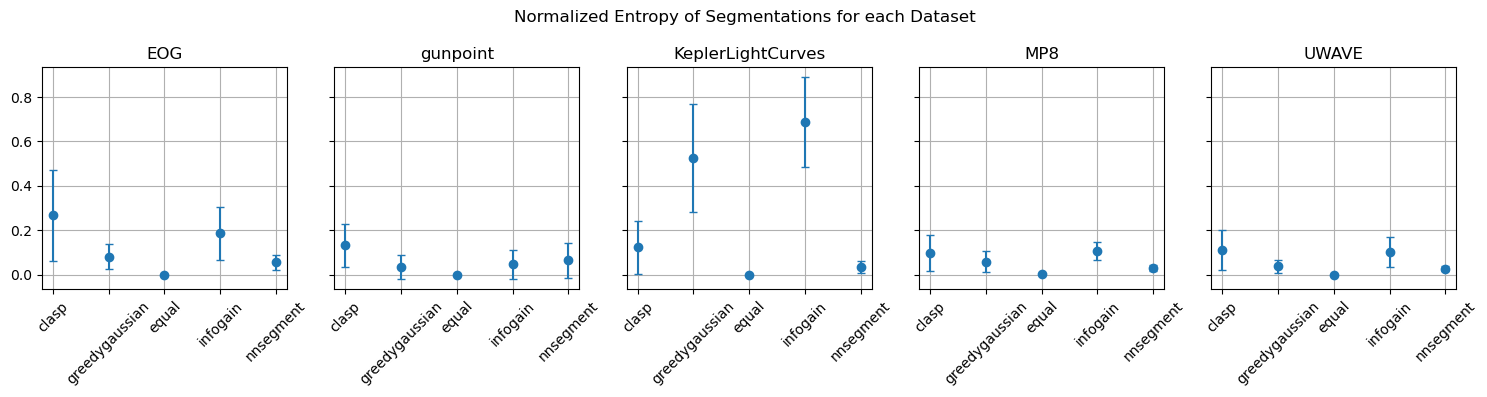

In [36]:
dataset_names = df["Dataset"].unique()
segmentation_names = df['Segmentation'].unique()

mask = (df["Metric"]=="segmentstats")
df2 = df.loc[mask, ["Dataset", "Segmentation", "Perturb", "Result"]]

fig, ax = plt.subplots(1, len(dataset_names), figsize = (15,4), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask = (df2["Dataset"]==dataset_name)
    df3 = df2.loc[mask, ["Segmentation", "Perturb", "Result"]]
    ax[i].set_title(dataset_name)

    mask = (df3["Perturb"]=="entropy_mean")
    df4 = df3.loc[mask, ["Segmentation", "Result"]]

    x = df4["Segmentation"].values
    y = 1-df4["Result"].values

    mask = (df3["Perturb"]=="entropy_std")
    df5 = df3.loc[mask, ["Segmentation", "Result"]]
    e = df5["Result"].values

    ax[i].errorbar(x, y, e, linestyle='None', marker='o', capsize=3)
    ax[i].grid()
    ax[i].tick_params("x", rotation=45)

fig.suptitle("Normalized Entropy of Segmentations for each Dataset")
fig.tight_layout()

min, max

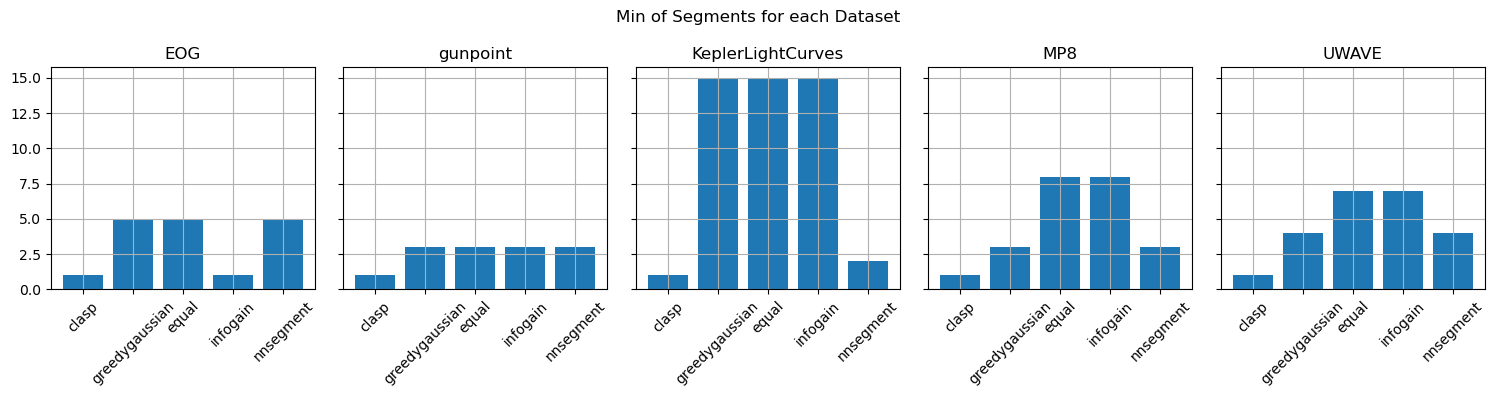

In [37]:
mask = (df["Metric"]=="segmentstats")
df2 = df.loc[mask, ["Dataset", "Segmentation", "Perturb", "Result"]]

fig, ax = plt.subplots(1, len(dataset_names), figsize = (15,4), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask = (df2["Dataset"]==dataset_name)
    df3 = df2.loc[mask, ["Segmentation", "Perturb", "Result"]]
    ax[i].set_title(dataset_name)

    mask = (df3["Perturb"]=="min_segments")
    df4 = df3.loc[mask, ["Segmentation", "Result"]]

    x = df4["Segmentation"].values
    y = df4["Result"].values


    ax[i].bar(x, y)
    ax[i].grid()
    ax[i].tick_params("x", rotation=45)

fig.suptitle("Min of Segments for each Dataset")
fig.tight_layout()

.% lesser

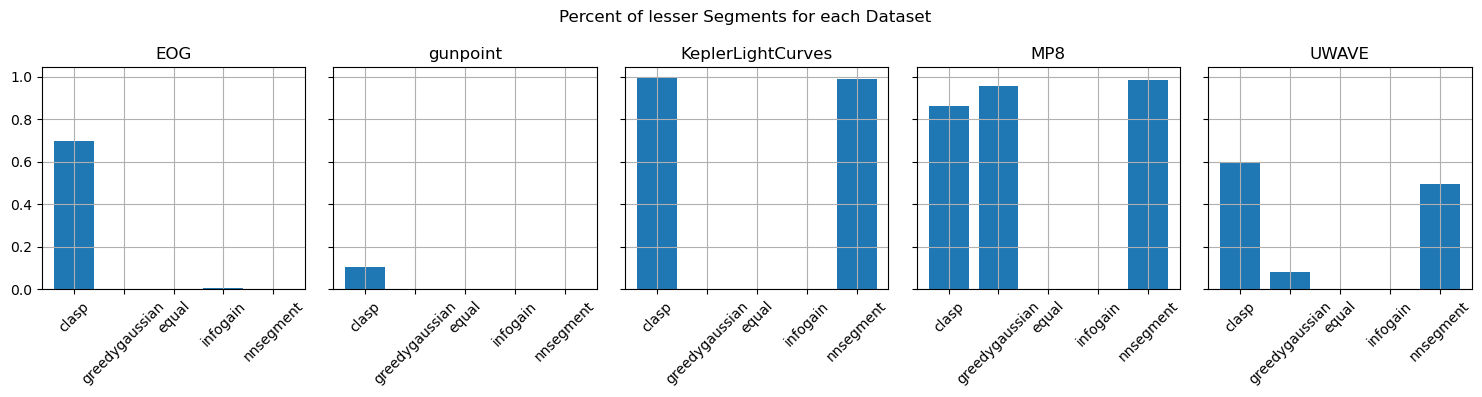

In [38]:
mask = (df["Metric"]=="segmentstats")
df2 = df.loc[mask, ["Dataset", "Segmentation", "Perturb", "Result"]]

fig, ax = plt.subplots(1, len(dataset_names), figsize = (15,4), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask = (df2["Dataset"]==dataset_name)
    df3 = df2.loc[mask, ["Segmentation", "Perturb", "Result"]]
    ax[i].set_title(dataset_name)

    mask = (df3["Perturb"]=="percent_lesser_segments")
    df4 = df3.loc[mask, ["Segmentation", "Result"]]

    x = df4["Segmentation"].values
    y = df4["Result"].values


    ax[i].bar(x, y)
    ax[i].grid()
    ax[i].tick_params("x", rotation=45)

fig.suptitle("Percent of lesser Segments for each Dataset")
fig.tight_layout()

.% lesser mean

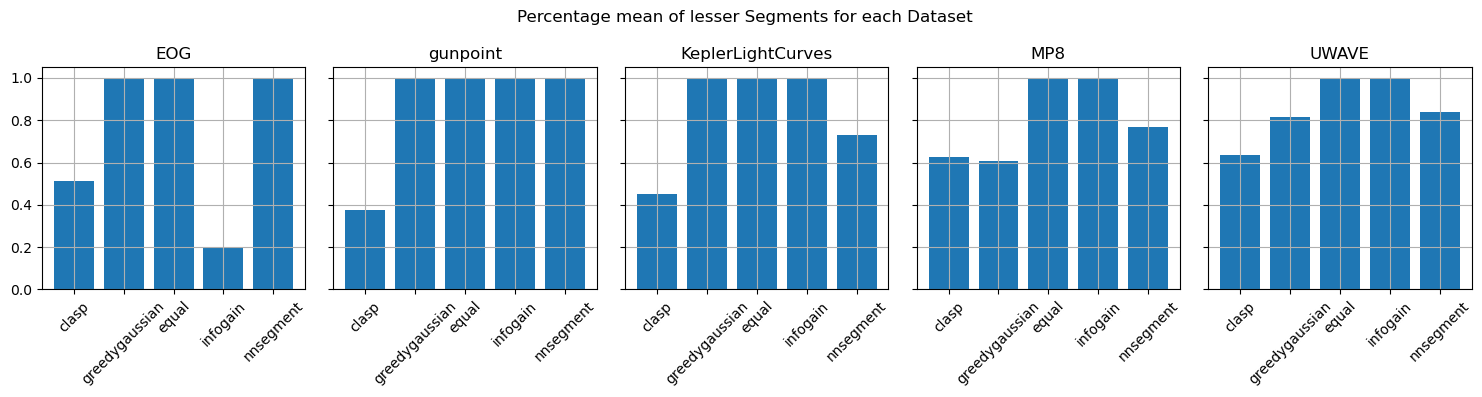

In [39]:
mask = (df["Metric"]=="segmentstats")
df2 = df.loc[mask, ["Dataset", "Segmentation", "Perturb", "Result"]]

fig, ax = plt.subplots(1, len(dataset_names), figsize = (15,4), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask = (df2["Dataset"]==dataset_name)
    df3 = df2.loc[mask, ["Segmentation", "Perturb", "Result"]]
    ax[i].set_title(dataset_name)

    mask = (df3["Perturb"]=="percent_mean_lesser_segments")
    df4 = df3.loc[mask, ["Segmentation", "Result"]]

    x = df4["Segmentation"].values
    y = df4["Result"].values


    ax[i].bar(x, y)
    ax[i].grid()
    ax[i].tick_params("x", rotation=45)

fig.suptitle("Percentage mean of lesser Segments for each Dataset")
fig.tight_layout()